In [1]:
import torch
import torchaudio
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("../")
from ad_utils import *
from torch.nn.utils import spectral_norm


cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]

X_train, X_test, y_train, y_test = train_test_split(normal_data, normal_label, test_size=0.2, random_state=42, shuffle=True)

NVIDIA A30
(872, 4500, 14) (872,)


# Cycle GAN

In [2]:
# Improved Residual Block for Time Series
class TimeSeriesResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)
        self.norm1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)
        self.norm2 = nn.BatchNorm1d(channels)
        self.activation = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        residual = x
        out = self.activation(self.norm1(self.conv1(x)))
        out = self.dropout(out)
        out = self.norm2(self.conv2(out))
        return self.activation(out + residual)

# Enhanced Generator for Time Series
class TimeSeriesGenerator(nn.Module):
    def __init__(self, input_channels=14, hidden_dim=128, n_residual_blocks=6):
        super().__init__()
        
        # Initial convolution
        self.initial = nn.Sequential(
            nn.Conv1d(input_channels, hidden_dim//2, kernel_size=7, padding=3),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(inplace=True)
        )
        
        # Downsampling layers
        self.down1 = nn.Sequential(
            nn.Conv1d(hidden_dim//2, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True)
        )
        
        self.down2 = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(hidden_dim*2),
            nn.ReLU(inplace=True)
        )
        
        # Residual blocks
        self.residual_blocks = nn.ModuleList([
            TimeSeriesResidualBlock(hidden_dim*2) for _ in range(n_residual_blocks)
        ])
        
        # Upsampling layers
        self.up1 = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim*2, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim, hidden_dim//2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(inplace=True)
        )
        
        # Final output layer
        self.final = nn.Sequential(
            nn.Conv1d(hidden_dim//2, input_channels, kernel_size=7, padding=3),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.initial(x)
        x = self.down1(x)
        x = self.down2(x)
        
        for block in self.residual_blocks:
            x = block(x)
            
        x = self.up1(x)
        x = self.up2(x)
        x = self.final(x)
        
        return x

# Enhanced Discriminator for Time Series
class TimeSeriesDiscriminator(nn.Module):
    def __init__(self, input_channels=14, hidden_dim=64):
        super().__init__()
        
        self.model = nn.Sequential(
            # Add spectral normalization to prevent discriminator from becoming too strong
            spectral_norm(nn.Conv1d(input_channels, hidden_dim, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            
            spectral_norm(nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm1d(hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            spectral_norm(nn.Conv1d(hidden_dim*2, hidden_dim*4, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm1d(hidden_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            spectral_norm(nn.Conv1d(hidden_dim*4, hidden_dim*8, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm1d(hidden_dim*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            spectral_norm(nn.Conv1d(hidden_dim*8, 1, kernel_size=4, padding=1)),
            nn.AdaptiveAvgPool1d(1)
        )
        
    def forward(self, x):
        return self.model(x).squeeze()

# Enhanced CycleGAN training function
def train_cyclegan_timeseries_stable(normal_data, device, epochs=200, batch_size=8, lr=2e-4):
    """
    Enhanced CycleGAN training with improved stability
    """
    print(f"Training CycleGAN on data shape: {normal_data.shape}")
    
    # Split data into two domains
    mid_point = len(normal_data) // 2
    domain_A = normal_data[:mid_point]
    domain_B = normal_data[mid_point:]
    
    # Convert to tensors
    tensor_A = torch.tensor(domain_A, dtype=torch.float32).permute(0, 2, 1)
    tensor_B = torch.tensor(domain_B, dtype=torch.float32).permute(0, 2, 1)
    
    dataset = TensorDataset(tensor_A, tensor_B)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize networks
    G_AB = TimeSeriesGenerator().to(device)
    G_BA = TimeSeriesGenerator().to(device)
    D_A = TimeSeriesDiscriminator().to(device)
    D_B = TimeSeriesDiscriminator().to(device)
    
    # **IMPROVED OPTIMIZERS** - Different learning rates for G and D
    optimizer_G = optim.Adam(
        list(G_AB.parameters()) + list(G_BA.parameters()),
        lr=lr, betas=(0.5, 0.999)
    )
    # Slower learning rate for discriminators to prevent collapse
    optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr/2, betas=(0.5, 0.999))
    optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr/2, betas=(0.5, 0.999))
        
    def adversarial_loss_smooth(pred, target_is_real):
        if target_is_real:
            # Use random labels between 0.8-1.0 for more robust training
            target = torch.ones_like(pred) * (0.8 + 0.2 * torch.rand_like(pred))
        else:
            # Use random labels between 0.0-0.2
            target = torch.zeros_like(pred) + 0.2 * torch.rand_like(pred)
        return nn.MSELoss()(pred, target)
    
    # Add gradient penalty for discriminators
    def gradient_penalty(discriminator, real_data, fake_data, device):
        batch_size = real_data.size(0)
        alpha = torch.rand(batch_size, 1, 1).to(device)
        
        interpolated = alpha * real_data + (1 - alpha) * fake_data
        interpolated.requires_grad_(True)
        
        pred = discriminator(interpolated)
        gradients = torch.autograd.grad(
            outputs=pred, inputs=interpolated,
            grad_outputs=torch.ones_like(pred),
            create_graph=True, retain_graph=True
        )[0]
        
        penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return penalty
    
    cycle_loss = nn.L1Loss()
    identity_loss = nn.L1Loss()
    
    # Training history
    history = {
        'G_loss': [], 'D_A_loss': [], 'D_B_loss': [],
        'cycle_loss': [], 'identity_loss': []
    }
    
    print("Starting stable training...")
    for epoch in range(epochs):
        epoch_G_loss = 0
        epoch_D_A_loss = 0
        epoch_D_B_loss = 0
        epoch_cycle_loss = 0
        epoch_identity_loss = 0
        
        for i, (real_A, real_B) in enumerate(dataloader):
            real_A, real_B = real_A.to(device), real_B.to(device)
            
            # **TRAIN DISCRIMINATORS MORE FREQUENTLY**
            for _ in range(2):  # Train discriminators twice per generator update
                
                # ============ Train Discriminator A ============
                optimizer_D_A.zero_grad()
                
                # Generate fake samples
                fake_A = G_BA(real_B).detach()
                
                pred_real_A = D_A(real_A)
                pred_fake_A = D_A(fake_A)
                
                loss_D_real_A = adversarial_loss_smooth(pred_real_A, True)
                loss_D_fake_A = adversarial_loss_smooth(pred_fake_A, False)
                
                loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
                loss_D_A.backward()
                optimizer_D_A.step()
                
                # ============ Train Discriminator B ============
                optimizer_D_B.zero_grad()
                
                fake_B = G_AB(real_A).detach()
                
                pred_real_B = D_B(real_B)
                pred_fake_B = D_B(fake_B)
                
                loss_D_real_B = adversarial_loss_smooth(pred_real_B, True)
                loss_D_fake_B = adversarial_loss_smooth(pred_fake_B, False)
                
                loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
                loss_D_B.backward()
                optimizer_D_B.step()
            
            # ============ Train Generators ============
            optimizer_G.zero_grad()
            
            # Identity loss (reduced weight)
            identity_B = G_AB(real_B)
            identity_A = G_BA(real_A)
            loss_identity = (identity_loss(identity_B, real_B) + 
                           identity_loss(identity_A, real_A)) * 2.0  # Reduced from 5.0
            
            # GAN loss
            fake_B = G_AB(real_A)
            fake_A = G_BA(real_B)
            
            pred_fake_B = D_B(fake_B)
            pred_fake_A = D_A(fake_A)
            
            loss_GAN_AB = adversarial_loss_smooth(pred_fake_B, True)
            loss_GAN_BA = adversarial_loss_smooth(pred_fake_A, True)
            
            # Cycle consistency loss
            recovered_A = G_BA(fake_B)
            recovered_B = G_AB(fake_A)
            loss_cycle = (cycle_loss(recovered_A, real_A) + 
                         cycle_loss(recovered_B, real_B)) * 10.0
            
            # Total generator loss
            loss_G = loss_GAN_AB + loss_GAN_BA + loss_cycle + loss_identity
            loss_G.backward()
            optimizer_G.step()
            
            # Accumulate losses
            epoch_G_loss += loss_G.item()
            epoch_D_A_loss += loss_D_A.item()
            epoch_D_B_loss += loss_D_B.item()
            epoch_cycle_loss += loss_cycle.item()
            epoch_identity_loss += loss_identity.item()
        
        # Average losses
        num_batches = len(dataloader)
        epoch_G_loss /= num_batches
        epoch_D_A_loss /= num_batches
        epoch_D_B_loss /= num_batches
        epoch_cycle_loss /= num_batches
        epoch_identity_loss /= num_batches
        
        # Store history
        history['G_loss'].append(epoch_G_loss)
        history['D_A_loss'].append(epoch_D_A_loss)
        history['D_B_loss'].append(epoch_D_B_loss)
        history['cycle_loss'].append(epoch_cycle_loss)
        history['identity_loss'].append(epoch_identity_loss)
        
        # Print progress and check for instability
        print(f"Epoch [{epoch+1}/{epochs}] - "
                f"G: {epoch_G_loss:.4f}, D_A: {epoch_D_A_loss:.4f}, D_B: {epoch_D_B_loss:.4f}, "
                f"Cycle: {epoch_cycle_loss:.4f}, Identity: {epoch_identity_loss:.4f}")
            
            # **STABILITY CHECK**
        if epoch_D_A_loss < 0.01 and epoch_D_B_loss < 0.01:
            print("Warning: Discriminator losses too low! Potential collapse detected.")
            # Optionally restart discriminators or adjust learning rates

    return G_AB, G_BA, history

# Generate synthetic data using CycleGAN
def generate_synthetic_data(generator, original_data, normalizer, device, num_samples=None):
    """
    Generate synthetic time series data using CycleGAN domain translation
    """
    if num_samples is None:
        num_samples = len(original_data)
    
    generator.eval()
    synthetic_samples = []
    
    # Use original data directly (already normalized in preprocessing)
    input_data = original_data[:num_samples]
    
    with torch.no_grad():
        # Convert to tensor format (batch, channels, seq_len)
        tensor_data = torch.tensor(input_data, dtype=torch.float32).permute(0, 2, 1)
        
        # Generate in batches
        batch_size = 32
        for i in range(0, len(tensor_data), batch_size):
            batch = tensor_data[i:i+batch_size].to(device)
            # Use CycleGAN generator to transform domain
            synthetic_batch = generator(batch)
            synthetic_samples.append(synthetic_batch.cpu())
        
        # Concatenate all batches
        synthetic_tensor = torch.cat(synthetic_samples, dim=0)
        
        # Convert back to original format (batch, seq_len, channels)
        synthetic_data = synthetic_tensor.permute(0, 2, 1).numpy()
    
    # Return requested number of samples
    return synthetic_data[:num_samples]

# Plotting function
def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].plot(history['G_loss'])
    axes[0, 0].set_title('Generator Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    
    axes[0, 1].plot(history['D_A_loss'], label='D_A')
    axes[0, 1].plot(history['D_B_loss'], label='D_B')
    axes[0, 1].set_title('Discriminator Losses')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    
    axes[1, 0].plot(history['cycle_loss'])
    axes[1, 0].set_title('Cycle Consistency Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    
    axes[1, 1].plot(history['identity_loss'])
    axes[1, 1].set_title('Identity Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    
    plt.tight_layout()
    plt.show()


# Train, and generate

Starting CycleGAN training for time series data...
Training CycleGAN on data shape: (552, 4500, 14)
Starting stable training...
Epoch [1/100] - G: 17.8868, D_A: 0.8352, D_B: 1.1573, Cycle: 14.2004, Identity: 2.7984
Epoch [2/100] - G: 15.2234, D_A: 0.0671, D_B: 0.1353, Cycle: 12.2197, Identity: 2.3411
Epoch [3/100] - G: 15.3103, D_A: 0.3664, D_B: 0.0746, Cycle: 11.3910, Identity: 2.2050
Epoch [4/100] - G: 13.1914, D_A: 0.0099, D_B: 0.1912, Cycle: 10.1771, Identity: 2.0130
Epoch [5/100] - G: 11.8648, D_A: 0.0176, D_B: 0.0336, Cycle: 9.0730, Identity: 1.7986
Epoch [6/100] - G: 11.7074, D_A: 0.0120, D_B: 0.2924, Cycle: 8.9437, Identity: 1.7278
Epoch [7/100] - G: 10.7287, D_A: 0.0082, D_B: 0.0507, Cycle: 8.1058, Identity: 1.6084
Epoch [8/100] - G: 10.3668, D_A: 0.0170, D_B: 0.0981, Cycle: 7.8989, Identity: 1.5632
Epoch [9/100] - G: 10.1514, D_A: 0.0102, D_B: 0.1367, Cycle: 7.5857, Identity: 1.5098
Epoch [10/100] - G: 10.6273, D_A: 0.2501, D_B: 0.0376, Cycle: 7.8854, Identity: 1.5507
Epoch [

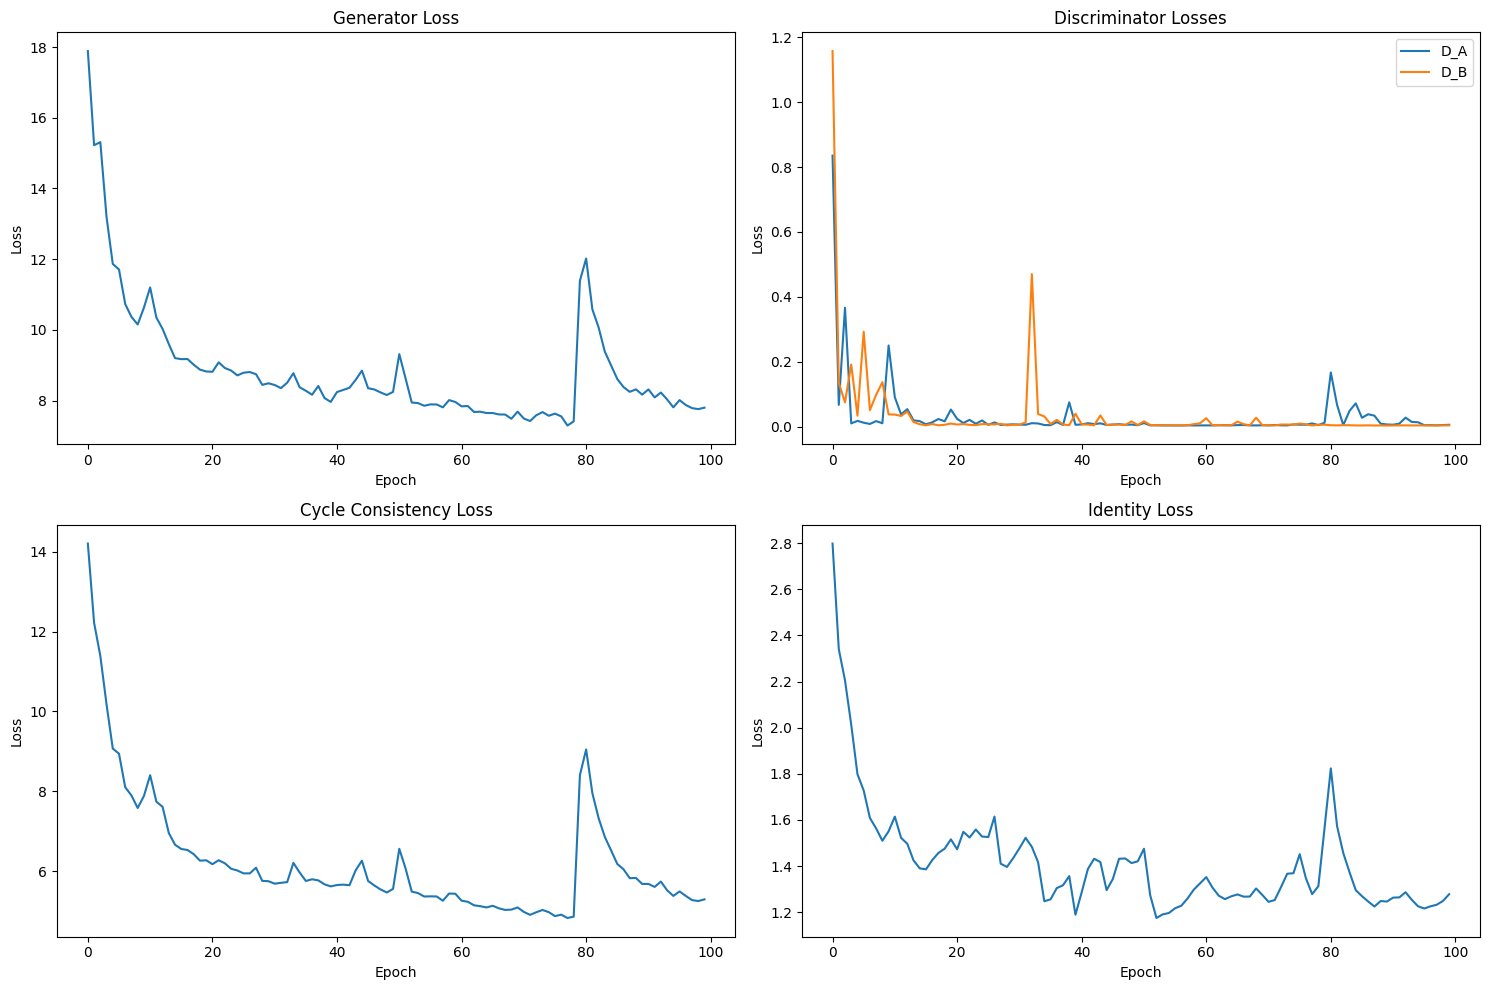

Generating synthetic data...
Original data shape: (690, 4500, 14)
Synthetic data shape: (690, 4500, 14)


In [3]:

# Example usage
print("Starting CycleGAN training for time series data...")
G_AB, G_BA, history = train_cyclegan_timeseries_stable(
    X_train, 
    device, 
    epochs=100,  # Reduced for testing
    batch_size=32,  # Smaller batch size for your data
    lr=0.005  # Slightly lower learning rate
)

# Plot training history
plot_training_history(history)

# Create a simple normalizer for data generation
normalizer = StandardScaler()
normalizer.fit(normal_data.reshape(-1, normal_data.shape[-1]))

# Generate synthetic data
print("Generating synthetic data...")
synthetic_data = generate_synthetic_data(G_AB, normal_data, normalizer, device, num_samples=len(normal_data))

print(f"Original data shape: {normal_data.shape}")
print(f"Synthetic data shape: {synthetic_data.shape}")




In [4]:
# ===============================
# FID SCORE EVALUATION
# ===============================

# Test the simplified FID calculation
print("Testing simplified FID calculation...")

# Use smaller subsets for testing
test_real = X_train[:100]  # Use 100 samples for testing
test_generated = synthetic_data[:100]

print(f"Test real data shape: {test_real.shape}")
print(f"Test generated data shape: {test_generated.shape}")

# Calculate FID score
fid_score = calculate_fid_score(
    real_data=test_real,
    fake_data=test_generated,
    device=device,
    sample_rate=1000,
)

if fid_score is not None:
    print(f"\n🎉 SUCCESS! FID Score: {fid_score:.4f}")
    
    # Interpret the score
    if fid_score < 10:
        quality = "Excellent"
    elif fid_score < 25:
        quality = "Good"
    elif fid_score < 50:
        quality = "Fair"
    elif fid_score < 100:
        quality = "Poor"
    else:
        quality = "Very Poor"
    
    print(f"Quality Assessment: {quality}")
else:
    print("❌ FID calculation failed. Please check the error messages above.")

Testing simplified FID calculation...
Test real data shape: (100, 4500, 14)
Test generated data shape: (100, 4500, 14)
Processing real data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Processing fake data for FID...
Processing 100 samples for FID calculation (299x299)...
Processed 0/100 samples
Calculating FID with 100 samples each...
Real images shape: torch.Size([100, 3, 299, 299])
Fake images shape: torch.Size([100, 3, 299, 299])
Real images range: [0.0000, 0.9816]
Fake images range: [0.0000, 0.9911]
After clamping - Real images range: [0.0000, 0.9816]
After clamping - Fake images range: [0.0000, 0.9911]
FID Score: 29.0699

🎉 SUCCESS! FID Score: 29.0699
Quality Assessment: Fair



COMPREHENSIVE ANOMALY DETECTION CROSS-VALIDATION EXPERIMENT
Normal samples: 552
Faulty samples: 182
Generated samples: 690
Cross-validation folds: 5

========================= FOLD 1/5 =========================
Fold 1 - Train normal: 441
Fold 1 - Test: 147 (111 normal, 36 faulty)
Fold 1 - Augmented normal data: 1131 samples
Processing data through feature extraction...
Processing 1131 samples with multi-channel approach...
Processed 0/1131 samples
Processed 100/1131 samples
Processed 200/1131 samples
Processed 300/1131 samples
Processed 400/1131 samples
Processed 500/1131 samples
Processed 600/1131 samples
Processed 700/1131 samples
Processed 800/1131 samples
Processed 900/1131 samples
Processed 1000/1131 samples
Processed 1100/1131 samples
Processing 147 samples with multi-channel approach...
Processed 0/147 samples
Processed 100/147 samples
Training autoencoder...
Epoch 1/200, Loss: 1.074590
Epoch 2/200, Loss: 0.612625
Epoch 3/200, Loss: 0.564024
Epoch 4/200, Loss: 0.561465
Epoch 5/

/home/maddie/SmartIoT-2025/GANs models/CycleGANs/../ad_utils.py:834: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(methods, rotation=45, ha='right')


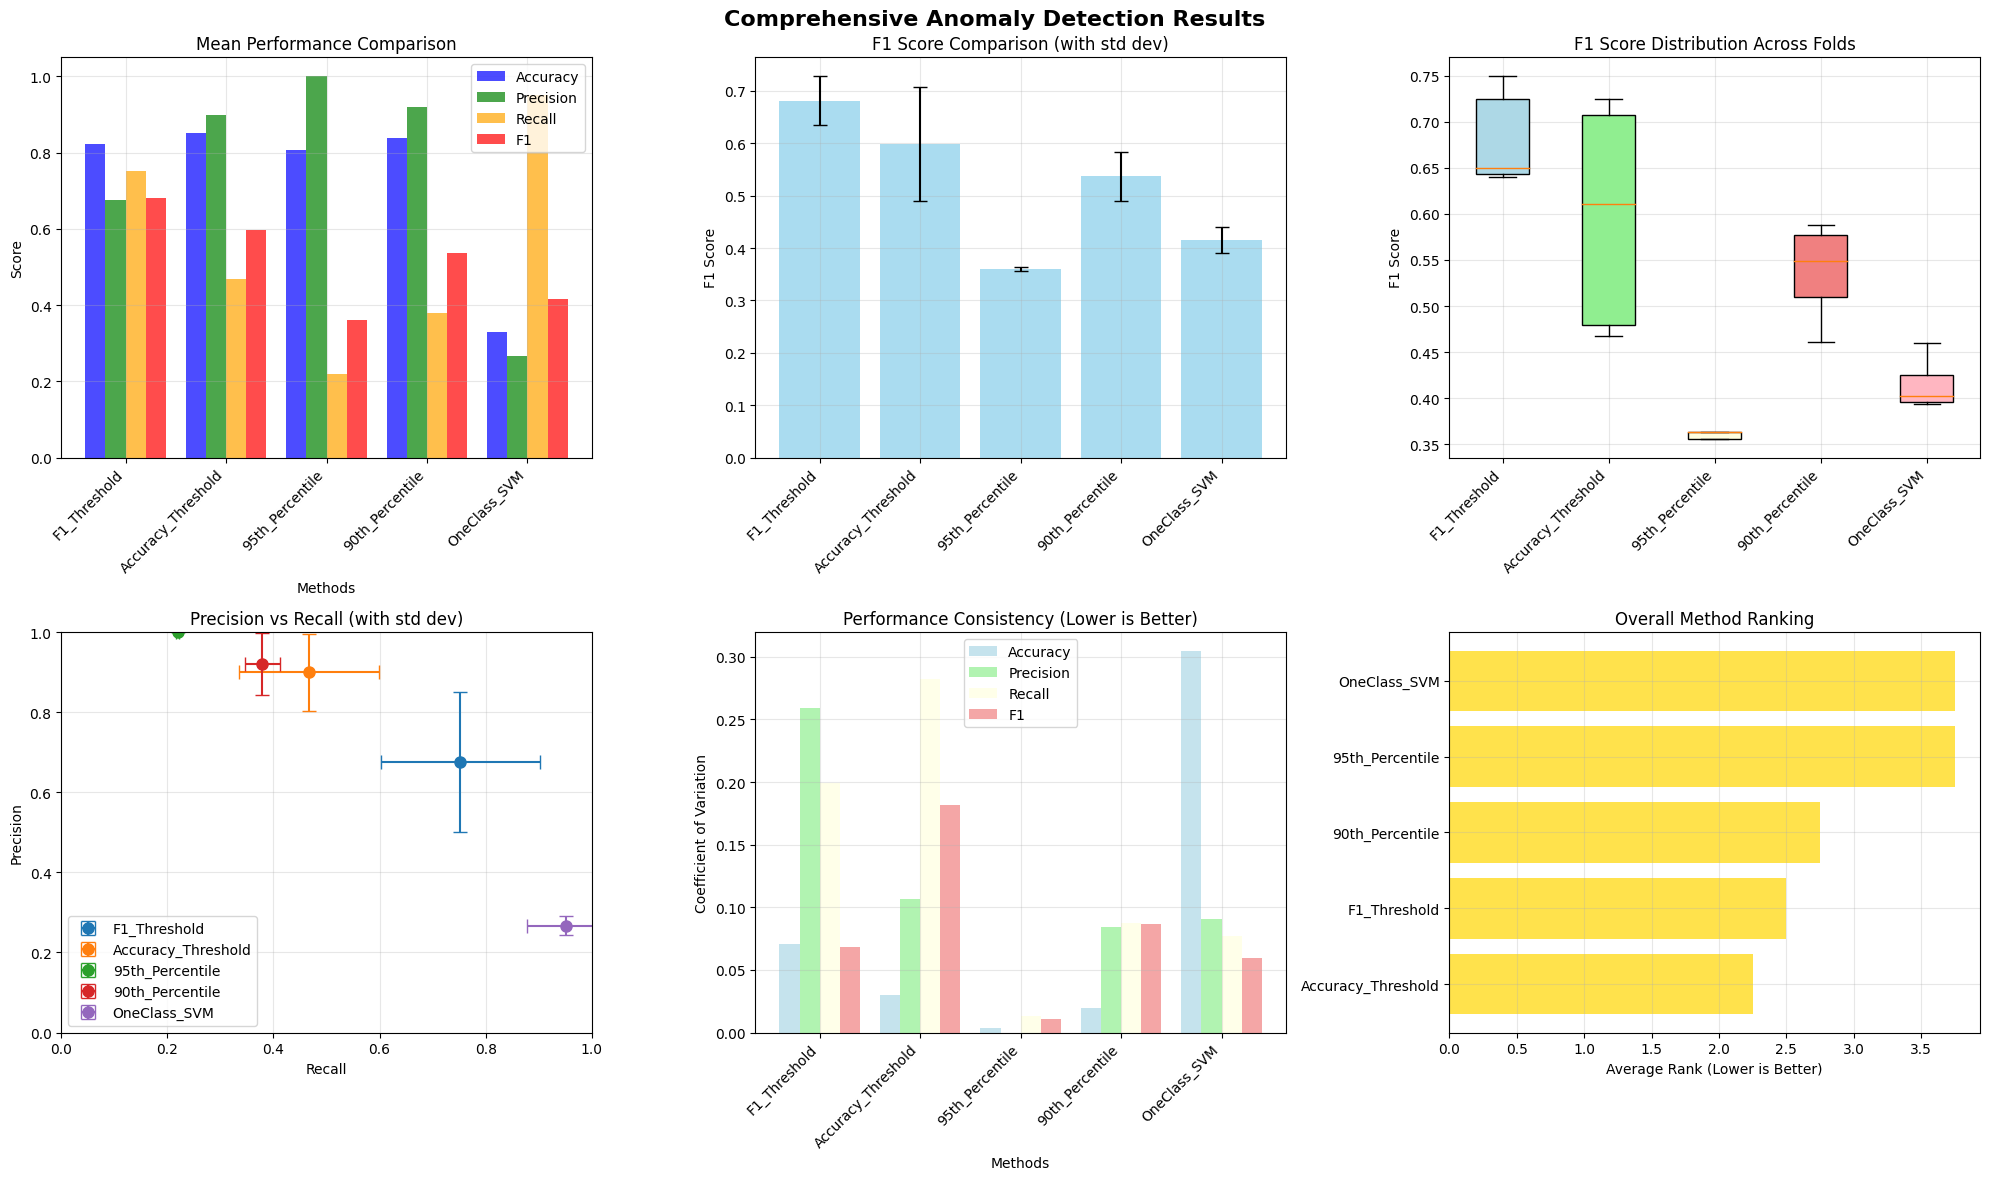


ANOMALY DETECTION RECOMMENDATIONS

🏆 BEST METHODS:
   • Best F1 Score: F1_Threshold (0.6814)
   • Best Accuracy: Accuracy_Threshold (0.8515)

📊 METHOD CHARACTERISTICS:
   • F1_Threshold          : High Recall (catches more anomalies), Variable
   • Accuracy_Threshold    : High Precision (fewer false alarms), Variable
   • 95th_Percentile       : High Precision (fewer false alarms), Stable
   • 90th_Percentile       : High Precision (fewer false alarms), Stable
   • OneClass_SVM          : High Recall (catches more anomalies), Stable

🎯 USE CASE RECOMMENDATIONS:
   • For Critical Systems (minimize false negatives): Use method with highest recall
   • For Cost-Sensitive Systems (minimize false alarms): Use method with highest precision
   • For Balanced Performance: Use F1_Threshold
   • For Simplicity: Use 95th_Percentile - no hyperparameter tuning needed
   • For Robustness: Use OneClass_SVM - adapts to data distribution



({'F1_Threshold': {'accuracy': {'mean': 0.8215823315627621,
    'std': 0.05781243455002797,
    'values': [0.8163265306122449,
     0.8163265306122449,
     0.891156462585034,
     0.7210884353741497,
     0.863013698630137]},
   'precision': {'mean': 0.6762635738245495,
    'std': 0.17534599314945934,
    'values': [0.6097560975609756,
     0.6153846153846154,
     1.0,
     0.47435897435897434,
     0.6818181818181818]},
   'recall': {'mean': 0.7524024024024024,
    'std': 0.1501519519411413,
    'values': [0.6944444444444444,
     0.6666666666666666,
     0.5675675675675675,
     1.0,
     0.8333333333333334]},
   'f1': {'mean': 0.6813933682509394,
    'std': 0.046285353417532614,
    'values': [0.6493506493506495,
     0.64,
     0.7241379310344828,
     0.6434782608695652,
     0.7499999999999999]}},
  'Accuracy_Threshold': {'accuracy': {'mean': 0.8515236231478893,
    'std': 0.025468861081113913,
    'values': [0.8435374149659864,
     0.8299319727891157,
     0.891156462585034,


In [5]:
run_comprehensive_cross_validation_experiment(X_train, faulty_data, device, synthetic_data, epochs=200, batch_size=32)